In [1]:
import os

if "script" in os.getcwd():
    os.chdir("..")
os.getcwd()
import warnings

warnings.filterwarnings("ignore")

import torch
import numpy as np
from src.logger.logger import configure_logging
from src.model.utils import get_model

import glob
import torchvision
import random
import cv2
import matplotlib.pyplot as plt
from loguru import logger

from torchvision import transforms


torch.manual_seed(1234)
np.random.seed(1234)

# logger = configure_logging()

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logger.info(f"Device : {device}")

from torch.nn.functional import mse_loss


def read_npy(path: str):
    with open(path, "rb") as f:
        a = np.load(f)
        a = a / np.max(a) * 255
    return a


def show_im(im, figsize=(20, 10)):
    plt.figure(figsize=figsize)
    if isinstance(im, list):
        plt.imshow(np.hstack([i for i in im]), cmap="gray")
    else:
        plt.imshow(im, cmap="gray")
    plt.show()


def show_multi_im(imgs: list, ratio=(5, 12), figsize=(20, 10)):
    index = 0
    f, axarr = plt.subplots(ratio[0], ratio[1], figsize=figsize)
    for r in range(ratio[0]):
        for c in range(ratio[1]):

            axarr[r, c].imshow(imgs[index], cmap="gray")
            index += 1
    plt.show()

2023-02-28 22:14:53.190 | INFO     | __main__:<cell line: 31>:31 - Device : cuda:0


In [28]:
best_paths = ["best_ssim.pth", "best_psnr.pth", "last.pt"]
best_path = best_paths[3]

dncnn_config = {
    "layers": 10,
    "channels": 1,
    "features": 192,
    "n_workers": 10,
    "scheduler_mode": min,
    "scheduler_patience": 1,
    "model_name": "Dncnn",
    "loss_function": "L2",
    "alpha_loss": [0.001],
    "weight": os.path.join(
        r"result\layers_Dncnn10_Trueclip_Truenormalize_sigrange3_3", best_path
    ),
    "data_dir": "data",
}

dnres_config = {
    "layers": 10,
    "channels": 1,
    "features": 192,
    "n_workers": 10,
    "scheduler_mode": min,
    "scheduler_patience": 1,
    "model_name": "dnresnet",
    "loss_function": "L2",
    "alpha_loss": [0.001],
    "weight": os.path.join(
        r"result\layers_dnresnet10_Trueclip_Truenormalize_sigrange3_3", best_path
    ),
    "data_dir": "data",
}

IndexError: list index out of range

In [29]:
dncnn_model = get_model(
    name=dncnn_config["model_name"],
    layers=dncnn_config["layers"],
    input_channels=dncnn_config["channels"],
    feature=dncnn_config["features"],
)
dnresnet_model = get_model(
    name=dnres_config["model_name"],
    layers=dnres_config["layers"],
    input_channels=dnres_config["channels"],
    feature=dnres_config["features"],
)
if cuda:
    dncnn_model = dncnn_model.cuda()
    dnresnet_model = dnresnet_model.cuda()
logger.info(os.getcwd())
try:
    checkpoint = torch.load(dncnn_config["weight"])["model"]
except:
    checkpoint = torch.load(dncnn_config["weight"])
dncnn_model.load_state_dict(checkpoint)
dncnn_model.eval()
del checkpoint

try:
    checkpoint = torch.load(dnres_config["weight"])["model"]
except:
    checkpoint = torch.load(dnres_config["weight"])
dnresnet_model.load_state_dict(checkpoint)
dnresnet_model.eval()
del checkpoint

transform = transforms.ToTensor()

2023-02-28 23:36:59.384 | INFO     | src.model.dnresnet:_initialize_weights:82 - init weight
2023-02-28 23:36:59.387 | INFO     | src.model.dnresnet:_initialize_weights:82 - init weight
2023-02-28 23:36:59.399 | INFO     | src.model.dnresnet:_initialize_weights:82 - init weight
2023-02-28 23:36:59.411 | INFO     | src.model.dnresnet:_initialize_weights:82 - init weight
2023-02-28 23:36:59.422 | INFO     | src.model.dnresnet:_initialize_weights:82 - init weight
2023-02-28 23:36:59.433 | INFO     | src.model.dnresnet:_initialize_weights:82 - init weight
2023-02-28 23:36:59.446 | INFO     | src.model.dnresnet:_initialize_weights:82 - init weight
2023-02-28 23:36:59.461 | INFO     | src.model.dnresnet:_initialize_weights:82 - init weight
2023-02-28 23:36:59.473 | INFO     | src.model.dnresnet:_initialize_weights:82 - init weight
2023-02-28 23:36:59.485 | INFO     | src.model.dnresnet:_initialize_weights:82 - init weight
2023-02-28 23:36:59.619 | INFO     | __main__:<cell line: 16>:16 - e:\

# Test with Test Data

In [30]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import pandas as pd
import json

phase = "test"
sigma = 15
num_samples = 60

data = glob.glob(f"{dnres_config['data_dir']}/{phase}/sigma_{sigma}/*.npy")
print(f"Number images of sigma {sigma}: {len(data)}")

clip = True
normalize = True


def get_infor(data, lib="torch"):
    lib = torch if lib == "torch" else np
    return f"Max: {lib.max(data)} - Min: {lib.min(data)}"


metric_table = pd.DataFrame(
    columns=["psnr_cnn10", "psnr_resnet10", "ssim_cnn10", "ssim_resnet10"]
)
columns = list(metric_table.keys())

for image_path in random.sample(data, num_samples):

    metric = {"psnr": {"resnet": 0, "cnn": 0}, "ssim": {"resnet": 0, "cnn": 0}}

    origin = read_npy(image_path.replace(f"sigma_{sigma}", "origin"))
    noised_im = read_npy(image_path)

    origin_tensor = transform(origin.astype(np.int32)).float()
    noised_im_tensor = transform(noised_im.astype(np.int32)).float()
    # logger.debug(f"origin_tensor: {get_infor(origin_tensor)}")
    # logger.debug(f"noised_im_tensor: {get_infor(noised_im_tensor)}")

    if clip:
        origin_tensor = origin_tensor.clamp(0, 255)
        noised_im_tensor = noised_im_tensor.clamp(0, 255)

    if normalize:
        origin_tensor = origin_tensor.div(255)
        noised_im_tensor = noised_im_tensor.div(255)
    # logger.info('------------------After------------------')
    # logger.debug(f"origin_tensor: {get_infor(origin_tensor)}")
    # logger.debug(f"noised_im_tensor: {get_infor(noised_im_tensor)}")
    dncnn_pred_noise = dncnn_model(noised_im_tensor.cuda().unsqueeze(0))
    dnresnet_pred_noise = dnresnet_model(noised_im_tensor.cuda().unsqueeze(0))

    denoise_dncnn = noised_im_tensor.cuda() - dncnn_pred_noise
    denoise_dnresnet = noised_im_tensor.cuda() - dnresnet_pred_noise

    if normalize:
        denoise_dncnn = denoise_dncnn * 255
        denoise_dnresnet = denoise_dnresnet * 255

    if clip:
        denoise_dncnn = denoise_dncnn.clamp(0, 255)
        denoise_dnresnet = denoise_dnresnet.clamp(0, 255)

    denoise_dncnn = (
        denoise_dncnn.cpu().detach().numpy().astype(np.uint8).squeeze(0).squeeze(0)
    )
    denoise_dnresnet = (
        denoise_dnresnet.cpu().detach().numpy().astype(np.uint8).squeeze(0).squeeze(0)
    )

    metric["psnr"]["cnn"] = psnr(origin.astype(np.uint8), denoise_dncnn)
    metric["psnr"]["resnet"] = psnr(origin.astype(np.uint8), denoise_dnresnet)

    metric["ssim"]["cnn"] = ssim(origin.astype(np.uint8), denoise_dncnn)
    metric["ssim"]["resnet"] = ssim(origin.astype(np.uint8), denoise_dnresnet)
    row = {
        columns[0]: metric["psnr"]["cnn"],
        columns[1]: metric["psnr"]["resnet"],
        columns[2]: metric["ssim"]["cnn"],
        columns[3]: metric["ssim"]["resnet"],
    }
    metric_table = metric_table.append(row, ignore_index=True)
    # print(json.dumps(metric, sort_keys=True, indent=4))
    # show_im([origin.astype(np.uint8), noised_im.astype(np.uint8), denoise_dncnn, denoise_dnresnet])

# print(metric_table)
print(f"Average: {metric_table.mean()}")

Number images of sigma 15: 60
Average: psnr_cnn10       22.277085
psnr_resnet10    23.144898
ssim_cnn10        0.672225
ssim_resnet10     0.823110
dtype: float64


# Random test samples

Number images of sigma 15: 60


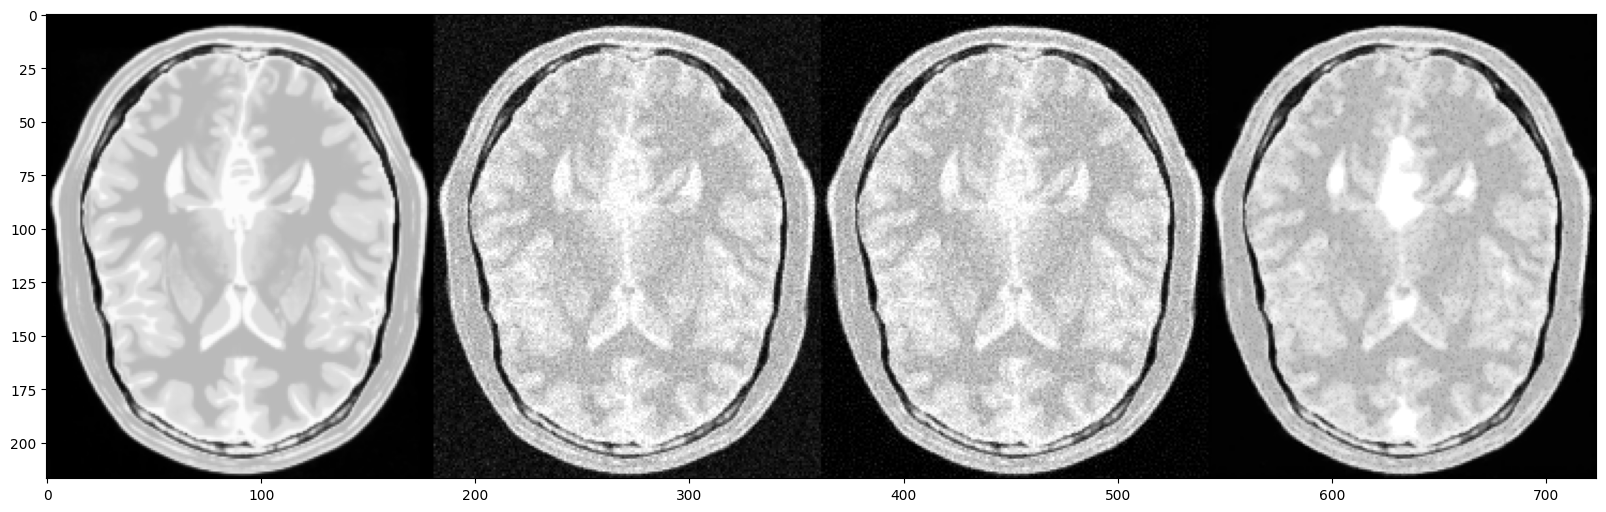

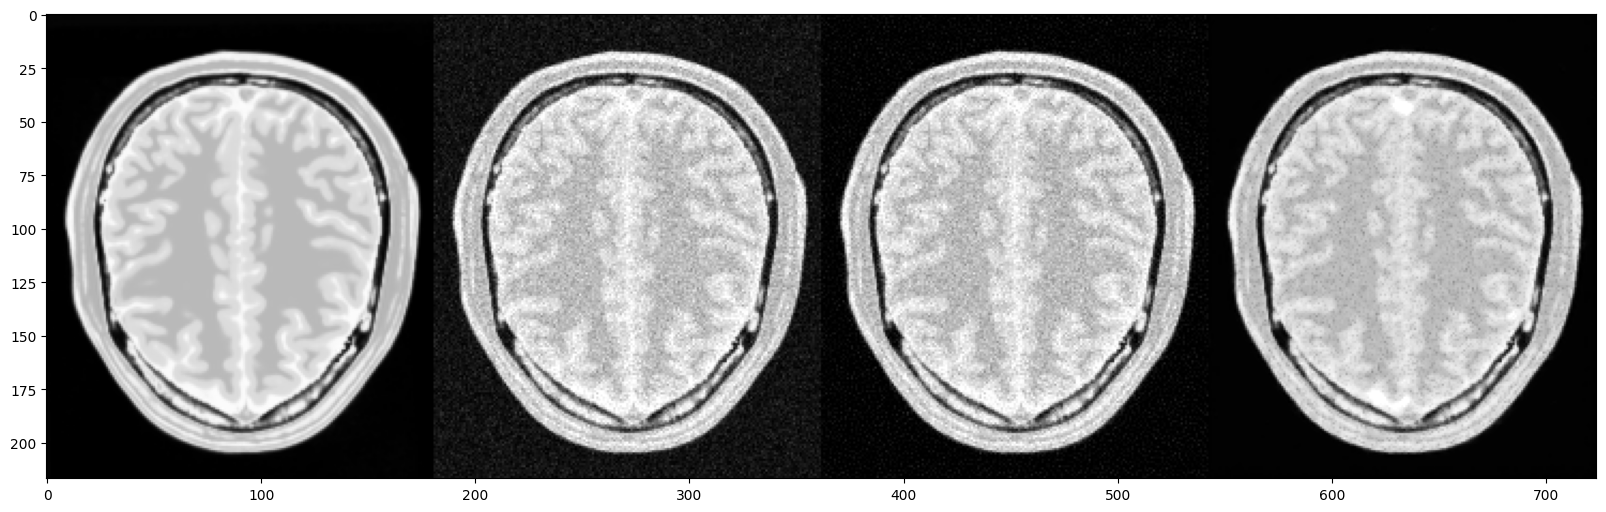

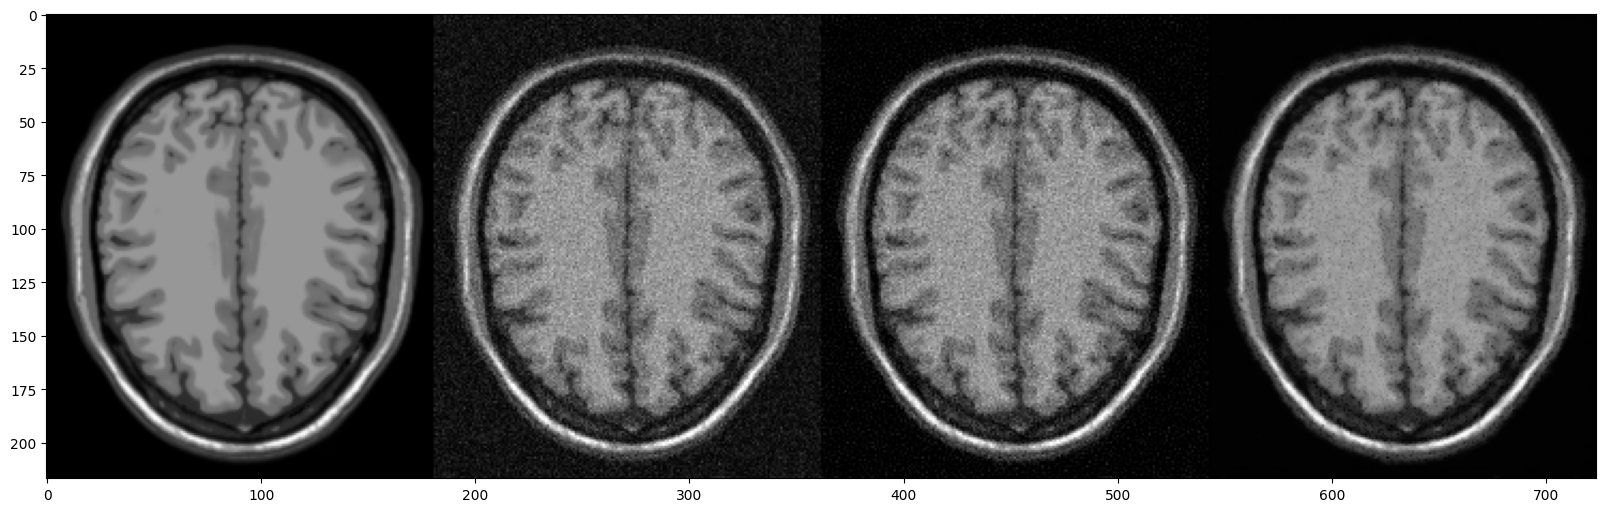

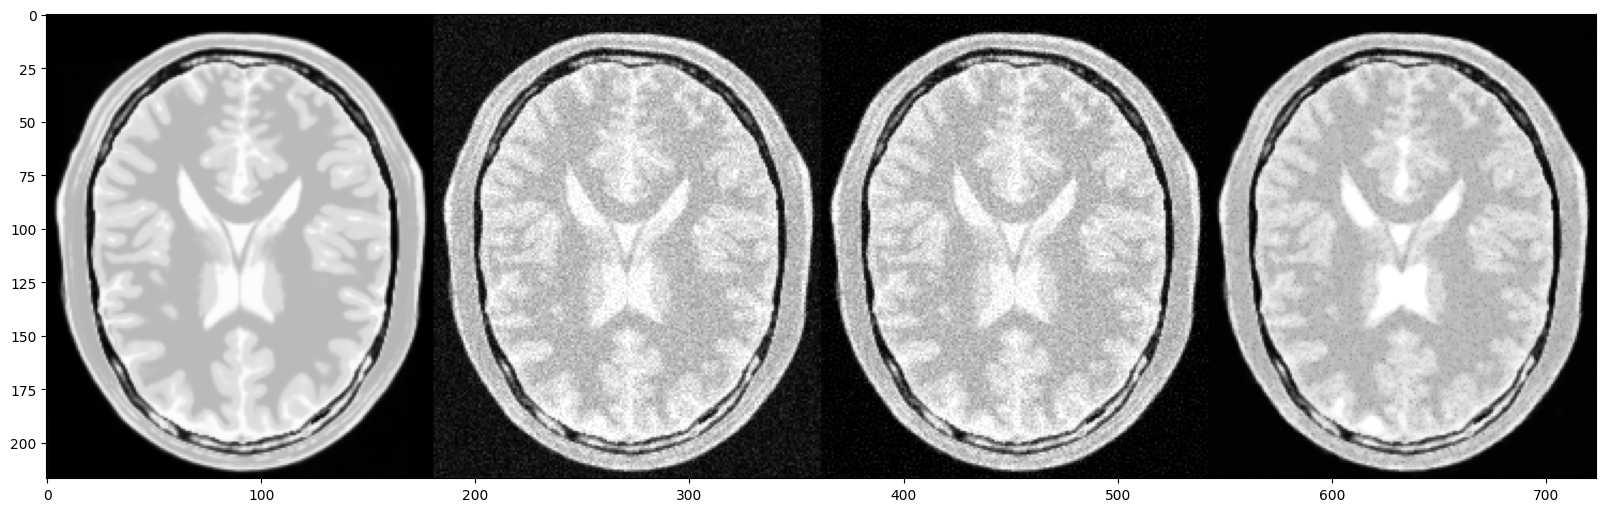

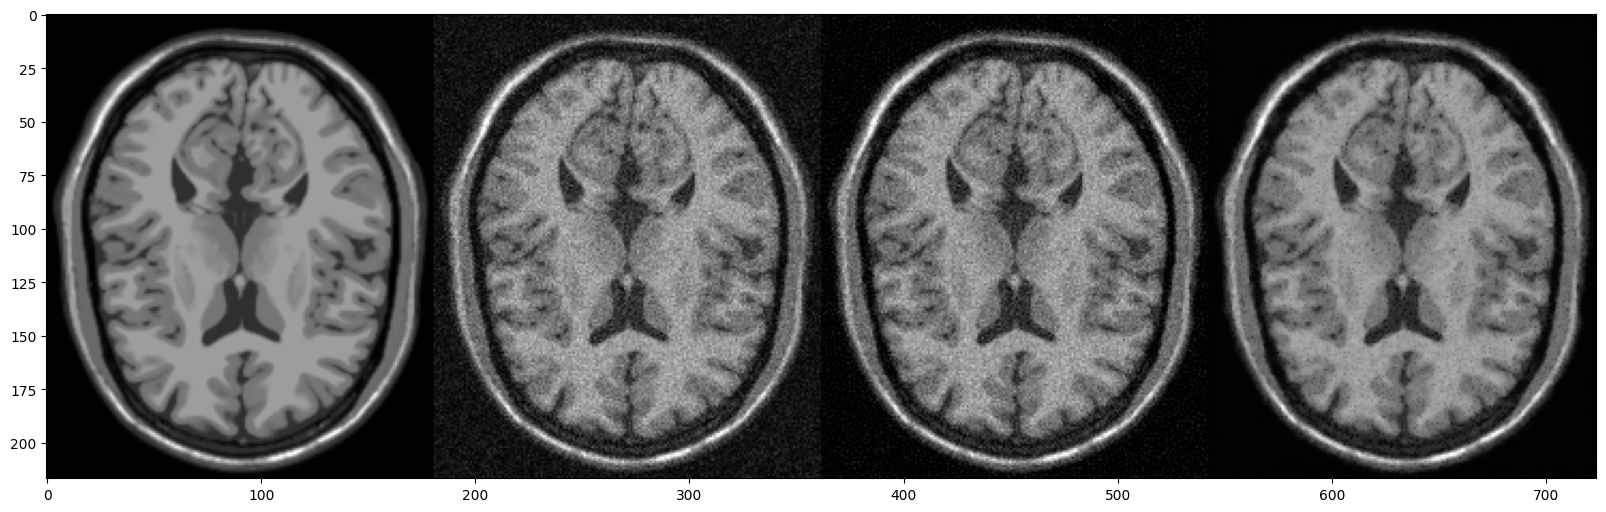

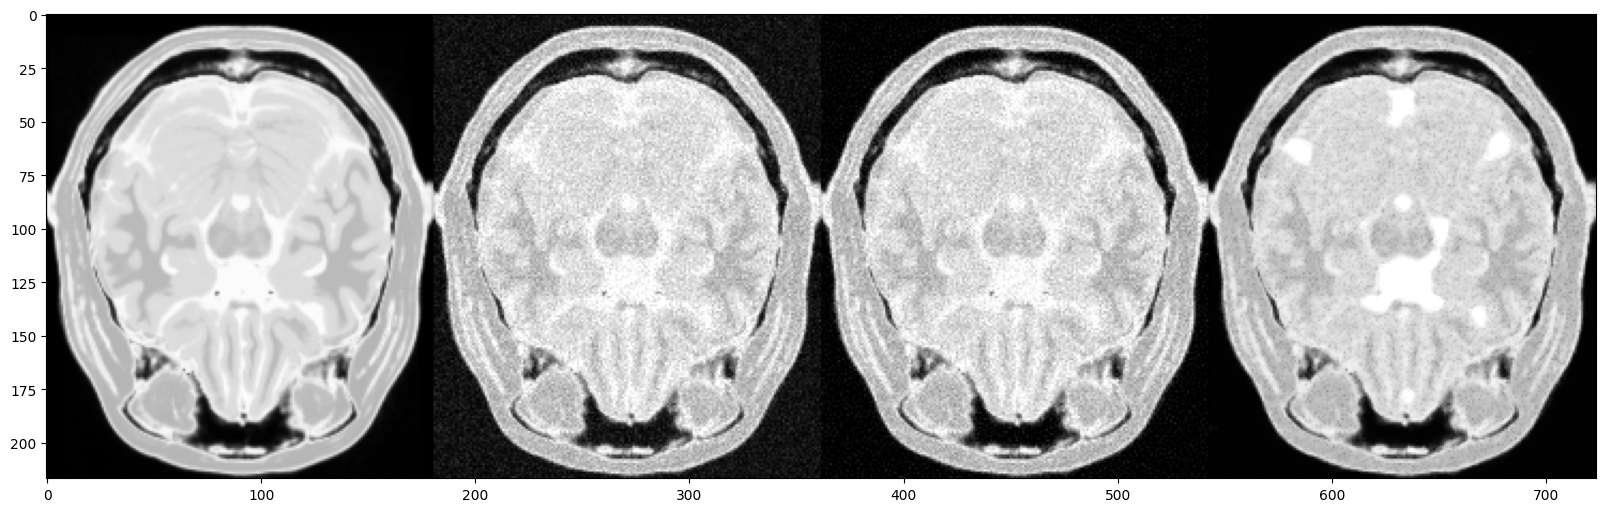

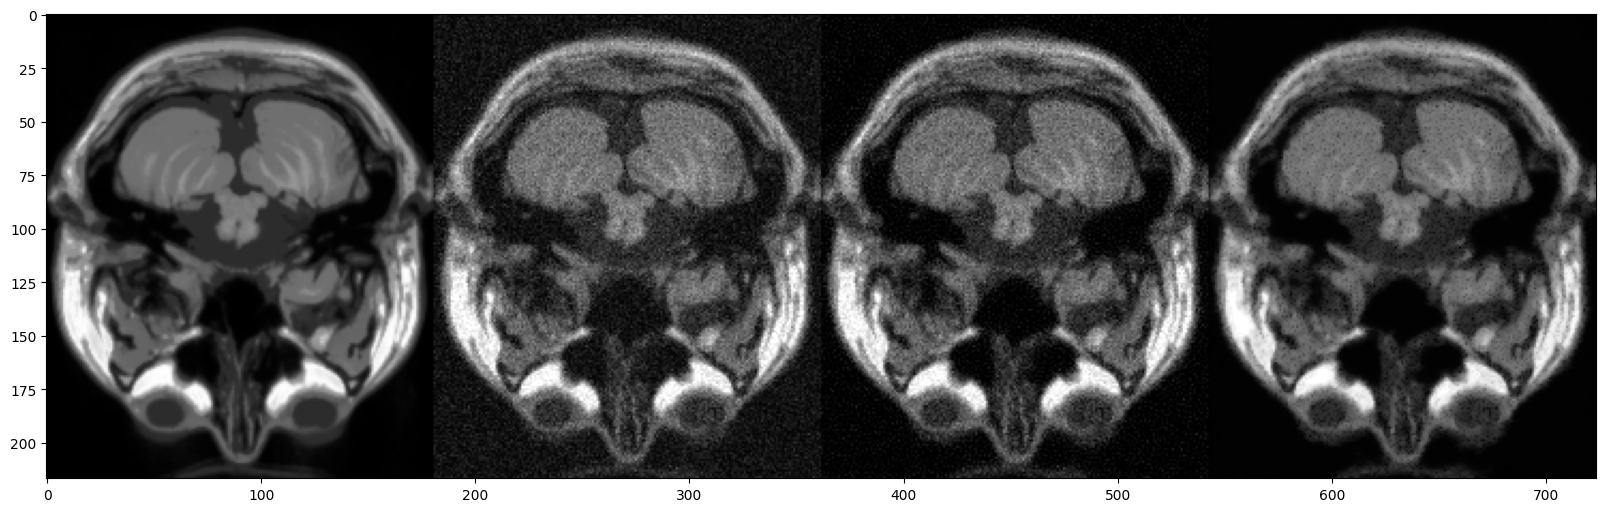

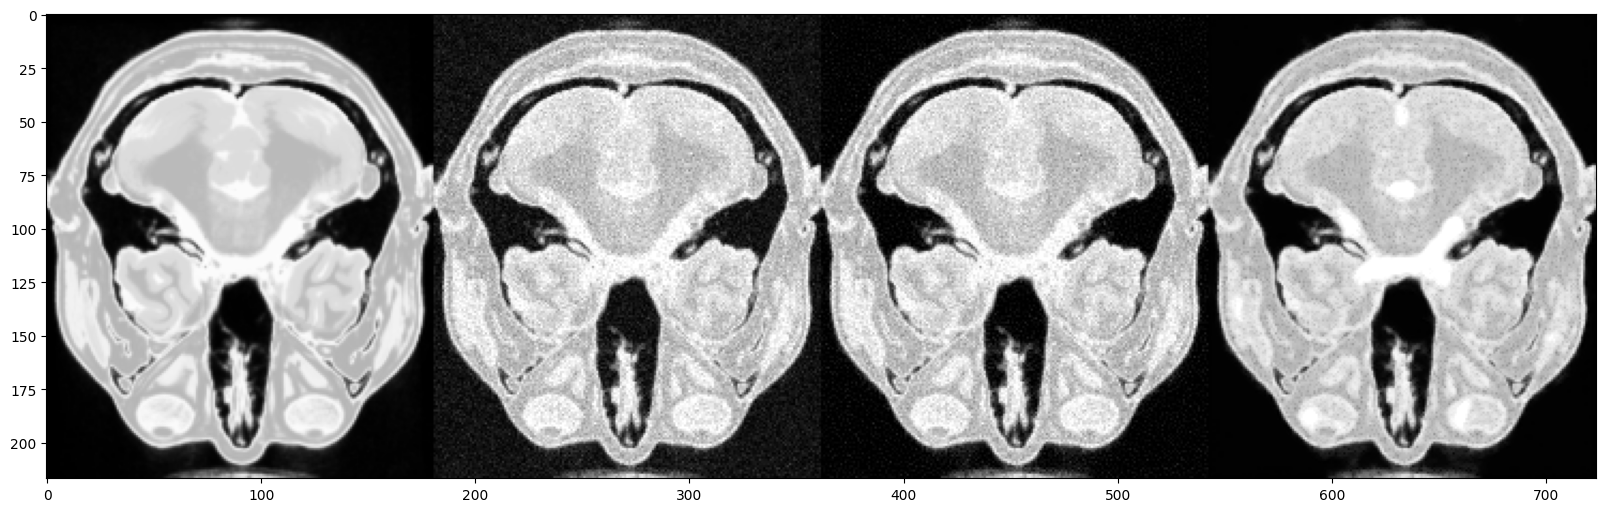

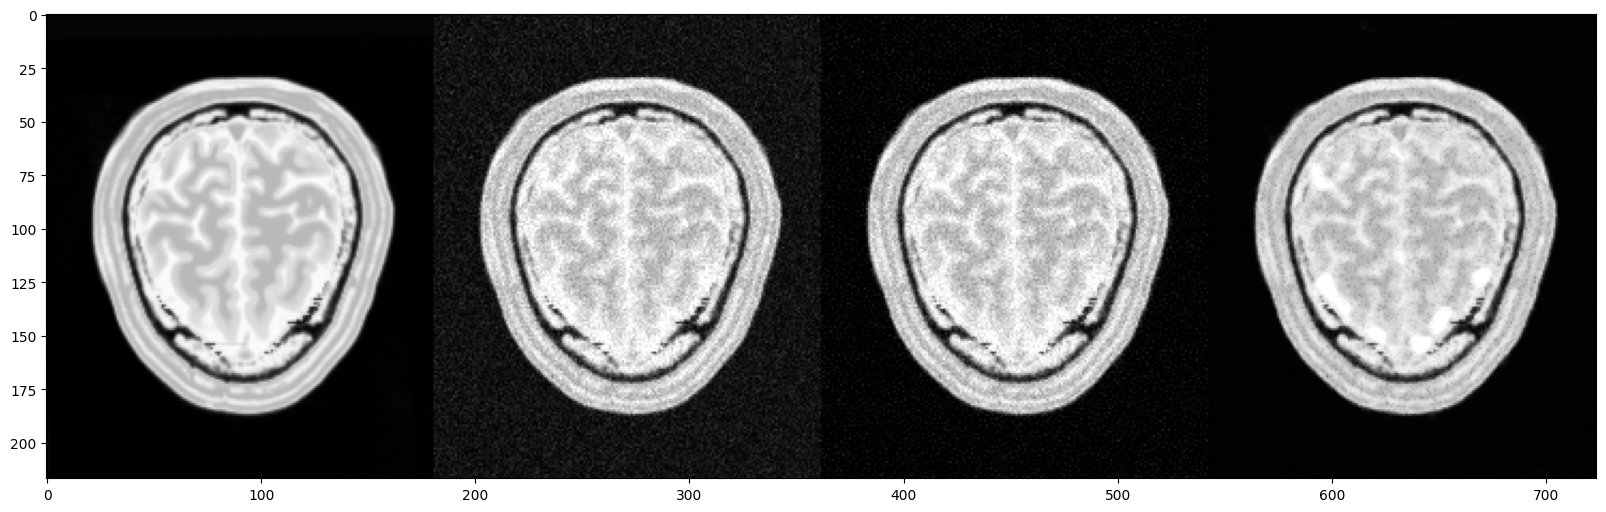

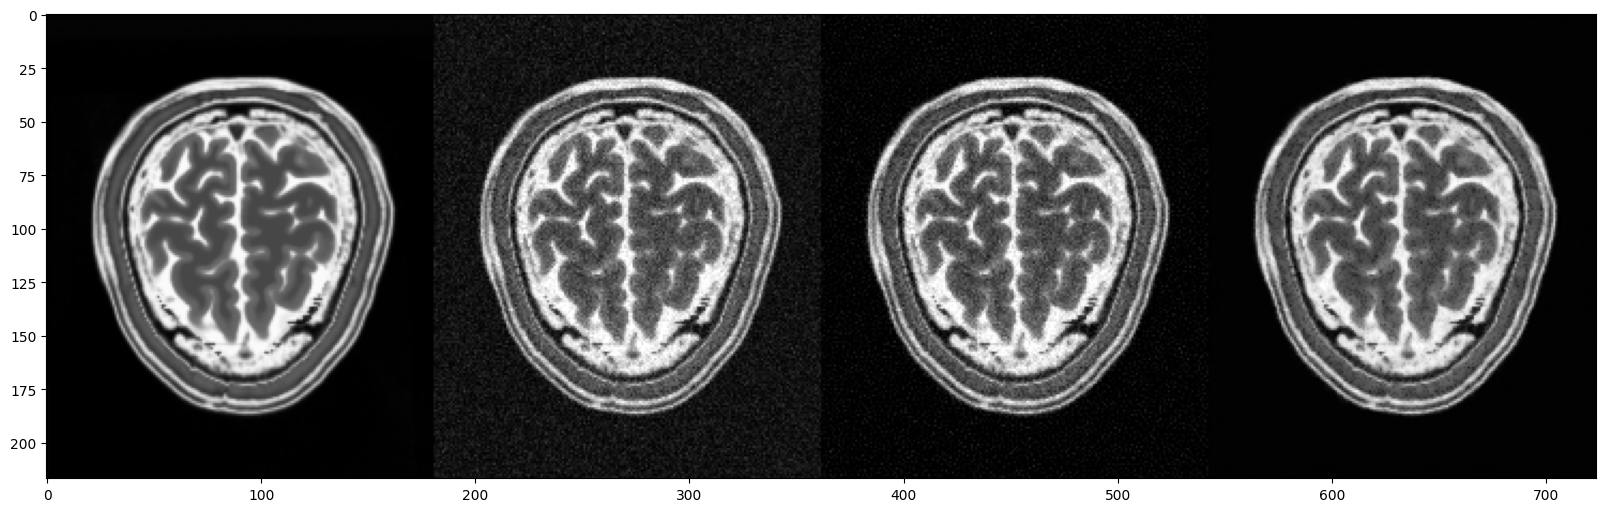

Average: psnr_cnn10       26.155783
psnr_resnet10    29.381153
ssim_cnn10        0.635710
ssim_resnet10     0.819472
dtype: float64


In [31]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import pandas as pd
import json

phase = "test"
sigma = 15
num_samples = 10


def make_noised_img(img, sigma=sigma):
    # Noise
    noise1 = np.random.randn(img.shape[0], img.shape[1]) * sigma
    noise2 = np.random.randn(img.shape[0], img.shape[1]) * sigma

    # Noisy Image
    # y = np.sqrt((x + noise1) * (x + noise1) + noise2 * noise2).clip(0,255).astype(np.uint8)
    return np.sqrt((img + noise1) * (img + noise1) + noise2 * noise2)


data = glob.glob(f"{dnres_config['data_dir']}/{phase}/origin/*.npy")
print(f"Number images of sigma {sigma}: {len(data)}")

clip = True
normalize = True


def get_infor(data, lib="torch"):
    lib = torch if lib == "torch" else np
    return f"Max: {lib.max(data)} - Min: {lib.min(data)}"


metric_table = pd.DataFrame(
    columns=["psnr_cnn10", "psnr_resnet10", "ssim_cnn10", "ssim_resnet10"]
)
columns = list(metric_table.keys())

for image_path in random.sample(data, num_samples):

    metric = {"psnr": {"resnet": 0, "cnn": 0}, "ssim": {"resnet": 0, "cnn": 0}}

    origin = read_npy(image_path)
    noised_im = make_noised_img(origin, sigma=sigma)
    if clip:
        noised_im = noised_im.clip(0, 255)

    origin_tensor = transform(origin.astype(np.int32)).float()
    noised_im_tensor = transform(noised_im.astype(np.int32)).float()
    # logger.debug(f"origin_tensor: {get_infor(origin_tensor)}")
    # logger.debug(f"noised_im_tensor: {get_infor(noised_im_tensor)}")

    if clip:
        origin_tensor = origin_tensor.clamp(0, 255)
        noised_im_tensor = noised_im_tensor.clamp(0, 255)

    if normalize:
        origin_tensor = origin_tensor.div(255)
        noised_im_tensor = noised_im_tensor.div(255)
    # logger.info('------------------After------------------')
    # logger.debug(f"origin_tensor: {get_infor(origin_tensor)}")
    # logger.debug(f"noised_im_tensor: {get_infor(noised_im_tensor)}")
    dncnn_pred_noise = dncnn_model(noised_im_tensor.cuda().unsqueeze(0))
    dnresnet_pred_noise = dnresnet_model(noised_im_tensor.cuda().unsqueeze(0))

    denoise_dncnn = noised_im_tensor.cuda() - dncnn_pred_noise
    denoise_dnresnet = noised_im_tensor.cuda() - dnresnet_pred_noise

    if normalize:
        denoise_dncnn = denoise_dncnn * 255
        denoise_dnresnet = denoise_dnresnet * 255

    if clip:
        denoise_dncnn = denoise_dncnn.clamp(0, 255)
        denoise_dnresnet = denoise_dnresnet.clamp(0, 255)

    denoise_dncnn = (
        denoise_dncnn.cpu().detach().numpy().astype(np.uint8).squeeze(0).squeeze(0)
    )
    denoise_dnresnet = (
        denoise_dnresnet.cpu().detach().numpy().astype(np.uint8).squeeze(0).squeeze(0)
    )

    metric["psnr"]["cnn"] = psnr(origin.astype(np.uint8), denoise_dncnn)
    metric["psnr"]["resnet"] = psnr(origin.astype(np.uint8), denoise_dnresnet)

    metric["ssim"]["cnn"] = ssim(origin.astype(np.uint8), denoise_dncnn)
    metric["ssim"]["resnet"] = ssim(origin.astype(np.uint8), denoise_dnresnet)
    row = {
        columns[0]: metric["psnr"]["cnn"],
        columns[1]: metric["psnr"]["resnet"],
        columns[2]: metric["ssim"]["cnn"],
        columns[3]: metric["ssim"]["resnet"],
    }
    metric_table = metric_table.append(row, ignore_index=True)
    # print(json.dumps(metric, sort_keys=True, indent=4))
    show_im(
        [
            origin.astype(np.uint8),
            noised_im.astype(np.uint8),
            denoise_dncnn,
            denoise_dnresnet,
        ]
    )

# print(metric_table)
print(f"Average: {metric_table.mean()}")